# Skin Lesions: Dataset Structure with Autoencoders

This notebook contains the definition and evaluation of a CNN-based autoencoder which aims to find a compressed representation of skin images; these images are labelled with their associated class:

- [Melanoma](https://es.wikipedia.org/wiki/Melanoma): **malign** cancer, one of the deadliest.
- [Nevus](https://en.wikipedia.org/wiki/Nevus): **benign** skin lesion (mole or birthmark).
- [Seborrheic keratosis](https://en.wikipedia.org/wiki/Seborrheic_keratosis): **benign** skin tumor.

![Skin Disease Classes](./images/skin_disease_classes.png)

The project uses the images from the [2017 ISIC Challenge on Skin Lesion Analysis Towards Melanoma Detection](https://challenge.isic-archive.com/landing/2017/). Although the challenge is already closed, information on the competition can be obtained from the official [website](https://challenge.isic-archive.com/landing/2017/).

I downloaded the dataset from the following links provided by Udacity to the non-committed folder `data/`, which is subdivided in the train, validation and test subfolders as well as class-name subfolders:

- [training data](https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/train.zip) (5.3 GB)
- [validation data](https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/valid.zip) (824.5 MB)
- [test data](https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/test.zip) (5.1 GB)

The images originate from the [ISIC Archive](https://www.isic-archive.com/).

Note that **the present notebook deals with the task of estimating the dataset structure**; if you are interested in the classification of the images, please open the notebook [skin_lesion_classification.ipynb](./skin_lesion_classification.ipynb); there, a CNN arhitecture based on the [ResNet50](https://en.wikipedia.org/wiki/Residual_neural_network) is built using transfer learning.

**Table of Contents**:

- [1. Load Dataset](#1.-Load-Dataset)
    - 1.1 Data Loaders
    - 1.2 Tensor Visualization Function
- [2. Model Definition and Training](#2.-Model-Definition-and-Training)
    - 2.1 Autoencoder
    - 2.2 Save and Load Functions
    - 2.3 Transform Function
    - 2.5 Training
- [3. Model Evaluation](#3.-Model-Evaluation)
    - 3.1 Test One Image
    - 3.1 Performance with the Test Split
    - 3.2 Evaluation Metrics and Plots
    - 3.3 Save Results
- [4. Structure Visualization (PCA, T-SNE](#4.-Structure-Visualization-(PCA,-T-SNE)
- [5. Conclusions and Notes](#5.-Conclusions-and-Notes)

## 1. Load Dataset

In [1]:
from glob import glob

ROOT_PATH = './data/'

# Get file paths for manual use
train_melanoma = list(glob(ROOT_PATH+"train/melanoma/*"))
train_nevus = list(glob(ROOT_PATH+"train/nevus/*"))
train_seborrheic = list(glob(ROOT_PATH+"train/seborrheic_keratosis/*"))
train_all = train_melanoma + train_nevus + train_seborrheic

test_melanoma = list(glob(ROOT_PATH+"test/melanoma/*"))
test_nevus = list(glob(ROOT_PATH+"test/nevus/*"))
test_seborrheic = list(glob(ROOT_PATH+"test/seborrheic_keratosis/*"))
test_all = test_melanoma + test_nevus + test_seborrheic

valid_melanoma = list(glob(ROOT_PATH+"valid/melanoma/*"))
valid_nevus = list(glob(ROOT_PATH+"valid/nevus/*"))
valid_seborrheic = list(glob(ROOT_PATH+"valid/seborrheic_keratosis/*"))
valid_all = valid_melanoma + valid_nevus + valid_seborrheic

### 1.1 Data Loaders

In [2]:
import os
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import numpy as np
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline

In [3]:
import torch
import torchvision.transforms as transforms
from torchvision import datasets

# When transfer-learning is used we need to adapt our dataset
# to how the pre-trained networks were trained.
# In the case of VGG16/DenseNet/ResNet/Inception,
# they were trained with ImageNet, that means:
# resizing to 224x224 & scaling each channel independently:
# mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]
# However, note that if we define our own network and train it, 
# we can use our own size and normalization,
# e.g.: 200x200, mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5]

trainpath = ROOT_PATH+'train'
testpath = ROOT_PATH+'test'
validpath = ROOT_PATH+'valid'
batch_size = 16 # 20
image_size = 224

# Training data with augmentation (recommended)
train_transforms = transforms.Compose([
                                       transforms.RandomRotation(10),
                                       transforms.Resize(230),
                                       #transforms.CenterCrop(224),
                                       #transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(image_size),
                                       transforms.ToTensor(), # map values to [0,1]
                                       transforms.Normalize([0.5, 0.5, 0.5], 
                                                            [0.5, 0.5, 0.5])])
# Test data without augmentation
test_transforms = transforms.Compose([ 
                                       transforms.Resize(230),
                                       transforms.CenterCrop(image_size),
                                       transforms.ToTensor(), # map values to [0,1]
                                       transforms.Normalize([0.5, 0.5, 0.5], 
                                                            [0.5, 0.5, 0.5])])

# Validation data without augmentation
valid_transforms = transforms.Compose([
                                       transforms.Resize(230),
                                       transforms.CenterCrop(image_size),
                                       transforms.ToTensor(), # map values to [0,1]
                                       transforms.Normalize([0.5, 0.5, 0.5], 
                                                            [0.5, 0.5, 0.5])])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(trainpath, transform=train_transforms)
test_data = datasets.ImageFolder(testpath, transform=test_transforms)
valid_data = datasets.ImageFolder(validpath, transform=valid_transforms)

# IMPORTANT: Set shuffle=False in the TEST data loader creation
# to preserve filename-sample link
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False) # shuffle=False!
validloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)

loaders = {}
loaders['train'] = trainloader
loaders['test'] = testloader
loaders['valid'] = validloader

In [4]:
# We can automatically access the class names
num_classes = len(train_data.classes)
class_names = [item.replace("_", " ") for item in train_data.classes]
print(class_names)

['melanoma', 'nevus', 'seborrheic keratosis']


### 1.2 Tensor Visualization Function

Note that Pytorch images are not loaded as numpy arrays, but as PIL images. Thus I define a simple function that given a PIL image visualizes it.

In [167]:
def visualize(image):
    '''Visualizes one tensor-image'''
    # Convert to numpy and (C,W,H) -> (W,H,C)
    img = image.cpu().numpy().squeeze().transpose((1, 2, 0))
    # Undo normalization
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    image = std * img + mean
    image = np.clip(image, 0, 1)
    plt.figure(figsize=(5,5))
    plt.imshow(image)

Target labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> ['melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma']


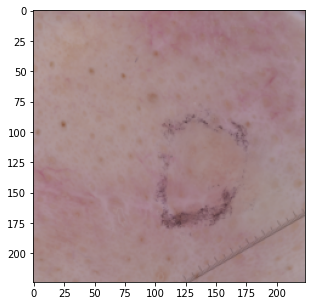

In [168]:
# Take next batch
data_iter = iter(testloader)
images, labels = next(data_iter)

# Print labels
print(f'Target labels: {labels.data.numpy()} -> {[class_names[i] for i in labels.data.numpy()]}')

# Visualize one image from the batch
image = images[0]
visualize(image)

## 2. Model Definition and Training

### 2.1 Autoencoder

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        
        # -- Encoder layers
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv4 = nn.Conv2d(256, 64, 3, padding=1)
        self.conv5 = nn.Conv2d(64, 8, 3, padding=1)

        # W_out = (W_in + 2P - F)/S + 1
        # (224 + 2*1 - 3)/1 + 1 = 224
        # (112 + 2*1 - 3)/1 + 1 = 112
        # (56 + 2*1 - 3)/1 + 1 = 56
        # (28 + 2*1 - 3)/1 + 1 = 28
        # (14 + 2*1 - 3)/1 + 1 = 14
        
        # MaxPool: / 2
        self.pool = nn.MaxPool2d(2, 2)
        
        # -- Decoder layers
        # A kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(8, 64, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(64, 256, 2, stride=2)
        self.t_conv3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.t_conv4 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.t_conv5 = nn.ConvTranspose2d(64, 3, 2, stride=2)        

    def encode(self, x):    
        # Conv 1
        x = F.relu(self.conv1(x)) # (B, 3, 224, 224) -> (B, 64, 224, 224)
        x = self.pool(x) # (B, 64, 224, 224) -> (B, 64, 112, 112)
        # Conv 2
        x = F.relu(self.conv2(x)) # (B, 64, 112, 112) -> (B, 128, 112, 112)
        x = self.pool(x) # (B, 128, 112, 112) -> (B, 128, 56, 56)
        # Conv 3
        x = F.relu(self.conv3(x)) # (B, 128, 56, 56) -> (B, 256, 56, 56)
        x = self.pool(x) # (B, 256, 56, 56) -> (B, 256, 28, 28)
        # Conv 4
        x = F.relu(self.conv4(x)) # (B, 256, 28, 28) -> (B, 64, 28, 28)
        x = self.pool(x) # (B, 64, 28, 28) -> (B, 64, 14, 14)
        # Conv 5
        x = F.relu(self.conv5(x)) # (B, 64, 14, 28) -> (B, 8, 14, 14)
        x = self.pool(x) # (B, 8, 14, 14) -> (B, 8, 7, 7):  8 x 7 x 7 = 392
    
        # Compressed representation: (B, 8, 7, 7): 8 x 7 x 7 = 392
        return x
            
    def decode(self, x):
        # T. Conv 1
        x = F.relu(self.t_conv1(x)) # (B, 8, 7, 7) -> (B, 64, 14, 14)
        # T. Conv 2
        x = F.relu(self.t_conv2(x)) # (B, 64, 14, 14) -> (B, 256, 28, 28)
        # T. Conv 3
        x = F.relu(self.t_conv3(x)) # (B, 256, 28, 28) -> (B, 128, 56, 56)
        # T. Conv 4
        x = F.relu(self.t_conv4(x)) # (B, 128, 56, 56) -> (B, 64, 112, 112)
        
        # T. Conv 5: Scale from 0 to 1
        x = torch.sigmoid(self.t_conv5(x)) # (B, 64, 112, 112) -> (B, 3, 224, 224)
        
        # Same size as input tensor: (B, 3, 224, 224)
        return x

    def forward(self, x):
        
        x = self.encode(x) # Compressed representation (B, 8, 7, 7): 8 x 7 x 7 = 392
        x = self.decode(x) # Same size as input tensor: (B, 3, 224, 224)
                
        return x

    
# initialize the NN
model = ConvAutoencoder()
print(model)

ConvAutoencoder(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(64, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(8, 64, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(64, 256, kernel_size=(2, 2), stride=(2, 2))
  (t_conv3): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
  (t_conv4): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
  (t_conv5): ConvTranspose2d(64, 3, kernel_size=(2, 2), stride=(2, 2))
)


In [8]:
# Check if CUDA is available
use_cuda = torch.cuda.is_available()

In [9]:
# Function that computes the number of trained parameters
# The larger the number, the longer training time
def get_num_parameters(net):
    model_parameters = filter(lambda p: p.requires_grad, net.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

In [10]:
num_parameters = get_num_parameters(model)
print(f'Number of model parameters to be trained: {num_parameters}')

Number of model parameters to be trained: 755659


### 2.2 Save and Load Functions

In [11]:
# Custom save & load functions
def save_model(filepath, model):
    torch.save(model.state_dict(), filepath)

def load_checkpoint(filepath, model):
    dev = 'cpu'
    #checkpoint = torch.load(filepath, map_location=torch.device(dev))
    checkpoint = torch.load(filepath, map_location=dev)
    model.load_state_dict(checkpoint)
    return model

In [12]:
filepath = './models/autoencoder_0.pt'
save_model(filepath, model)
model = load_checkpoint(filepath, model)

### 2.3 Transform Function

In [13]:
def transform(img_path, model, use_cuda):
    '''
    Use autoencode to transform an image:
    compress it and expand it.
    If the model is trained correctly, the expanded image
    should be similar to the input.
    
    Args:
        img_path: path to an image
        
    Returns:
        transformed image tensor
    '''

    # Note: transforms takes PIL formatted images, not numpy arrays
    img = Image.open(img_path) 
    
    # ImageNet dataset requires a specific mean & std normalization
    data_transforms = transforms.Compose([
        transforms.Resize(230),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])

    # Apply data data transformations and add a dimension for batches
    img_batch = data_transforms(img).unsqueeze(0)

    if use_cuda:
        model = model.cuda()
        img_batch = img_batch.to("cuda", dtype=torch.float)
    
    # Set in evaluation mode! (De-activate dropout, etc.)
    model.eval()
    
    # Predict. Apply softmax to convert logits
    with torch.no_grad():
        # Prediction
        img_compr = model.encode(img_batch)
        img_trans = model.decode(img_compr)
        img_compr = img_compr.squeeze(0).cpu()
        img_trans = img_trans.squeeze(0).cpu()
    
    # Transform compressed representation to a vector
    img_compr = img_compr.view(1, -1)
    
    return img_compr, img_trans

In [14]:
img_path = train_all[0]
print(img_path)
img_compr, img_trans = transform(img_path, model, use_cuda)
# Check sizes
print(img_compr.numpy().shape)
print(img_trans.size())

./data/train/melanoma/ISIC_0000031.jpg
(1, 392)
torch.Size([3, 224, 224])


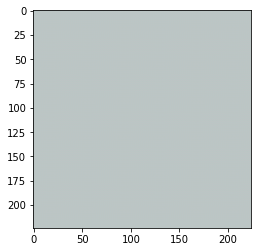

In [15]:
# Since the autoecoder is not trained, we should see a gray image
visualize(img_trans)

### 2.4 Training

In [16]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) # 0.01, 0.003
#optimizer = optim.SGD(model.parameters(), lr=0.001) # 0.01, 0.003

In [17]:
import time

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """Returns trained model"""
    valid_loss_min = np.Inf
    loss_history = {'train': [], 'valid': []}
 
    if use_cuda:
        model = model.cuda()
        
    for epoch in range(1, n_epochs+1):
        train_loss = 0.0
        valid_loss = 0.0
        num_images_train = 0
        num_images_valid = 0
        
        ###################
        # Train the model #
        ###################
        model.train()

        t1 = time.time()
            
        for batch_idx, (data, target) in enumerate(loaders['train']):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            optimizer.zero_grad() # reset gradients

            img_trans = model(data) # forward pass
            loss = criterion(img_trans, data) # compute loss

            loss.backward() # compute gradient / backpropagation
            optimizer.step() # update weights
            
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            #train_loss += loss.item()
            #num_images_train += data.size(0)
            
            if batch_idx%20 == 0:
                #print(f'Epoch: {epoch}, Training Loss: {train_loss/num_images_train:.6f} ')
                print(f'Epoch: {epoch}, Training Loss: {train_loss:.6f} ')
            
        ######################    
        # Validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            with torch.no_grad():
                img_trans = model(data) # forward pass
                loss = criterion(img_trans, data) # compute loss
                valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
                #valid_loss += loss.item()
                #num_images_valid += data.size(0)
        
        #train_loss /= len(loaders['train'].dataset)
        #valid_loss /= len(loaders['valid'].dataset)
        #train_loss /= num_images_train
        #valid_loss /= num_images_valid
        loss_history['train'].append(train_loss)
        loss_history['valid'].append(valid_loss)
        
        t2 = time.time()
        duration = t2-t1
        
        print('-> Epoch: {} \tTrain. Loss: {:.6f} \tVal. Loss: {:.6f} \tDuration: {:.2f} sec.'.format(
            epoch, 
            train_loss,
            valid_loss,
            duration
            ))
        
        if valid_loss < valid_loss_min:
            save_model(save_path, model)
    
    return model, loss_history

In [18]:
# Train the model
filepath = './models/autoencoder_best.pt'
n_epochs = 20 # 100

#from workspace_utils import active_session
#with active_session():

model, loss = train(n_epochs, loaders, model, optimizer, criterion, use_cuda, filepath)

Epoch: 1, Training Loss: 0.275763 
Epoch: 1, Training Loss: 0.216000 
Epoch: 1, Training Loss: 0.152445 
Epoch: 1, Training Loss: 0.128060 
Epoch: 1, Training Loss: 0.114732 
Epoch: 1, Training Loss: 0.105779 
Epoch: 1, Training Loss: 0.098867 
-> Epoch: 1 	Train. Loss: 0.097534 	Val. Loss: 0.047085 	Duration: 2573.90 sec.
Epoch: 2, Training Loss: 0.072325 
Epoch: 2, Training Loss: 0.063754 
Epoch: 2, Training Loss: 0.057970 
Epoch: 2, Training Loss: 0.057225 
Epoch: 2, Training Loss: 0.057682 
Epoch: 2, Training Loss: 0.056804 
Epoch: 2, Training Loss: 0.056047 
-> Epoch: 2 	Train. Loss: 0.056020 	Val. Loss: 0.038509 	Duration: 2397.69 sec.
Epoch: 3, Training Loss: 0.080197 
Epoch: 3, Training Loss: 0.054926 
Epoch: 3, Training Loss: 0.053682 
Epoch: 3, Training Loss: 0.052248 
Epoch: 3, Training Loss: 0.051094 
Epoch: 3, Training Loss: 0.050587 
Epoch: 3, Training Loss: 0.049876 
-> Epoch: 3 	Train. Loss: 0.049878 	Val. Loss: 0.036672 	Duration: 1532.16 sec.
Epoch: 4, Training Loss: 

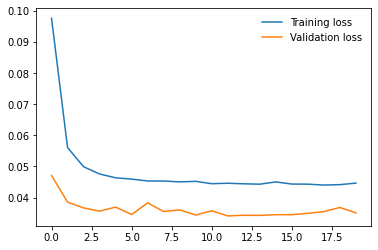

In [19]:
# Plot the loss evolution
from matplotlib import pyplot as plt
plt.plot(loss['train'][:], label='Training loss')
plt.plot(loss['valid'][:], label='Validation loss')
plt.legend(frameon=False)

It seems that the model is biased, i.e., it is underfitting; I conclude that because the loss decays very fast at the begining and then it mantains its value. I should try with a more complex model.

## 3. Evaluation

In [31]:
# Load the model that got the best validation accuracy
filepath = './models/autoencoder_best.pt'
model = load_checkpoint(filepath, model)

### 3.1 Test One Image

I show one real input and a transformed image; unfortunately, in this first version, the transformed image is still very blurry.

In [226]:
# Get an image path
img_path = train_all[3]
print(img_path)
# Transform the image with the autoencoder: encode + decode
img_compr, img_trans = transform(img_path, model, use_cuda)
# Check sizes
print(img_compr.numpy().shape)
print(img_trans.size())

./data/train/melanoma/ISIC_0014722.jpg
(1, 392)
torch.Size([3, 224, 224])


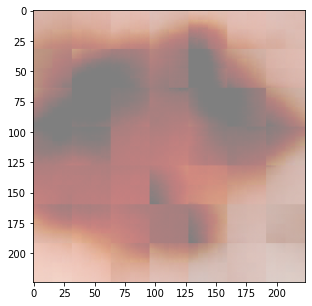

In [227]:
# Transformed/Decoded image
visualize(img_trans)
plt.savefig('./images/melanoma_sample_autoencoder.png',dpi=150,transparent=False,bbox_inches='tight')

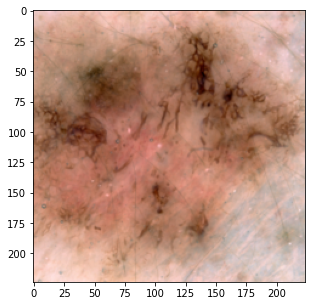

In [228]:
# Real input image
img = Image.open(img_path) 
data_transforms = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
img_batch = data_transforms(img).unsqueeze(0)
visualize(img_batch)
plt.savefig('./images/melanoma_sample_real.png',dpi=150,transparent=False,bbox_inches='tight')

### 3.2 Performance with the Test Split

In [89]:
import pandas as pd

def test(loaders, model, criterion, use_cuda, batch_size):

    # Monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    
    # Track samples: filename, y_true, y_pred
    # IMPORTANT: Set shuffle=False in the data loader creation
    # to preserve filename-sample link
    filenames = []
    targets = []
    imgs_compressed = []
    
    if use_cuda:
        model = model.cuda()
    
    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test'],0):
        # Move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # Get filenames
        for i in range(target.size(0)):
            sample_fname, _ = loaders['test'].dataset.samples[batch_idx*batch_size + i]
            filenames.append(sample_fname)
            targets.append(target.cpu()[i].item())
            #print(sample_fname)
        with torch.no_grad():
            # Forward pass: encode -> decode
            img_compr = model.encode(data)
            img_trans = model.decode(img_compr)
            # Calculate the loss
            loss = criterion(img_trans, data)
        # Update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # Get compressed representations as vectors
        c = img_compr.cpu().view(img_compr.size(0),-1)
        for i in range(c.size(0)):
            imgs_compressed.append(list(c[i].numpy()))
        
    print('Test Loss: {:.6f}\n'.format(test_loss))
    
    # Save results dataframe
    table = {'filename':filenames, 'targets':targets, 'images':imgs_compressed}
    df = pd.DataFrame(table)
    
    return df

In [90]:
# Call test function    
df = test(loaders, model, criterion, use_cuda, batch_size)

Test Loss: 0.053150



In [92]:
images_compressed = np.array(list(df['images'].values))
print(images_compressed.shape)

(600, 392)


## 4. Structure Visualization (PCA, T-SNE)

In [95]:
images_compressed = np.array(list(df['images'].values))
targets = df['targets']
filenames = df['filename']

In [96]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [99]:
scaler = StandardScaler()
scaler.fit(images_compressed)
scaled_data = scaler.transform(images_compressed)

#### PCA n=2

In [174]:
pca = PCA(n_components=2)
pca.fit(scaled_data)

PCA(n_components=2)

In [175]:
x_pca = pca.transform(scaled_data)

In [176]:
x_pca.shape

(600, 2)

In [177]:
class_names

['melanoma', 'nevus', 'seborrheic keratosis']

In [185]:
# Plot data points in new base coloring the class
# We see the groups are clearly separable!
# We could apply a classifier on x_pca now, much easier
# PCA can be understood as a compression algorithm: 30 features -> 2 features
def plot_dataset(X, title):
    fontsize=14
    plt.figure(figsize=(7,7))
    target_names = [class_names[i] for i in list(targets)]
    #print(target_names)
    scatter = plt.scatter(X[:,0], X[:,1], c=targets, alpha=0.75)
    plt.xlabel('First Component',fontsize=fontsize)
    plt.ylabel('Second Component',fontsize=fontsize)
    legend_elements = scatter.legend_elements()
    #print(legend_elements[1][0])
    legend_elements[1][0] = class_names[0]
    legend_elements[1][1] = class_names[1]
    legend_elements[1][2] = class_names[2]
    plt.legend(*legend_elements,fontsize=fontsize)
    plt.title(title, fontsize=fontsize+2)

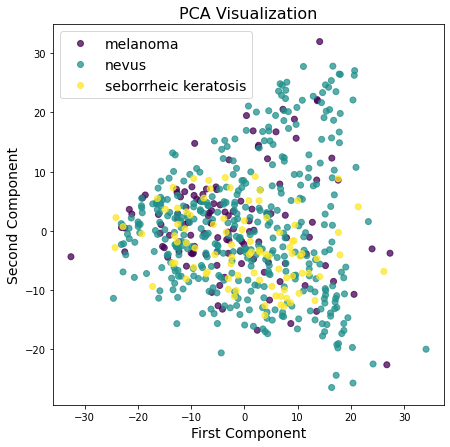

In [190]:
plot_dataset(x_pca, title="PCA Visualization")
plt.savefig('./images/pca.png',dpi=150,transparent=False,bbox_inches='tight')

#### t-SNE n=2

In [180]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(scaled_data)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 600 samples in 0.009s...
[t-SNE] Computed neighbors for 600 samples in 0.154s...
[t-SNE] Computed conditional probabilities for sample 600 / 600
[t-SNE] Mean sigma: 5.511986
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.064362
[t-SNE] KL divergence after 300 iterations: 0.699470


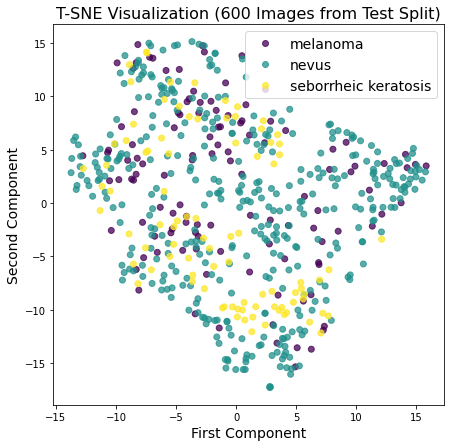

In [191]:
plot_dataset(tsne_results, title="T-SNE Visualization (600 Images from Test Split)")
plt.savefig('./images/t_sne.png',dpi=150,transparent=False,bbox_inches='tight')

## 5. Conclusions and Notes

First autoencoder with transpose convolutions and 700k parameters:

- The autoencoder is biased: it underfits the dataset, because the learning curves decrease fast at t he begining and don't change much later on.
- The transformed images are quite different/low resolution compared to the orginal ones; it's difficult that the commpressed representations contain enough information to distinguish between classes.
- The transpose convolutions create checkerboard artifacts, as reported by [Odena et al.](https://distill.pub/2016/deconv-checkerboard/).
- As expected, the T-SNE transformation and reduction to 2D doesn't shown clearnly differentiated point clusters.
- It probably makes more sense to use the train split for the T-SNE visualization; however, I would need to set shuffle=False in the data loader to be able to track sample filenames easily.
- If the T-SNE visualization shows distinct clusters, I can try to find similar images simply by using the dot product distance between image vectors.
- How to adress those problems:
    - Add more depth to the filters.
    - Add linear layers in the bottleneck.
    - Aim first for an order of magnitude larger network ans see if the behavior repeats (i.e., 7M)
    - Use upsampling instead of transpose convolution (to soolver the checkerboard artifacts)